# Wave Combinator Session Data Exploration

This template is designed to help you explore per-session data from the Wave Combinator game.
It presents statistics and visualizations to help you understand characteristics of data for the given file,
and makes it easy to tweak the code to further explore your data.

# Environment Setup and Import

In [52]:
import os
print(os.getcwd())
!pip install --quiet --no-input -r ../../requirements.txt --log ./pip-installations.log

c:\Users\subsc\Documents\_work\FieldDay\OpenGameData\opengamedata-samples\WAVES\explore


In [53]:
# Standard Libraries
from pathlib import Path
from pprint import pprint
from zipfile import ZipFile
# 3rd-party Libraries
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display
from OGDUtils.general.fileio import FileAPI, FileTypes
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

Change pandas `max_rows` and `max_columns`

 *Note: There may be other variables to manually change. Look the "Set Variables" section.*

In [54]:
pd.options.display.max_columns = 4000 #@param {type:"integer"}
pd.options.display.max_rows = 60 #@param {type:"integer"}

## Retrieve Data Files

#### Please change the settings below to configure which game/server location you want to use.

<!-- `ogd_server` : The file server that contains the actual data files -->
* `game_id` : The game whose data you want to access.
* `mode` : The kind of data you want to retrieve. Should be one of `FileTypes.PLAYER`, `FileTypes.POPULATION`, `FileTypes.SESSION`, `FileTypes.EVENTS` or `FileTypes.ALL_EVENTS`

In [ ]:
game_id = 'JOWILDER'
mode    = FileTypes.EVENTS

In [ ]:
months_list = FileAPI.GetAvailableMonths(game_id)
print(f"The available months are:")
pprint(months_list, compact=True)

The available months are:
['3/2019', '4/2019', '5/2019', '6/2019', '7/2019', '8/2019', '9/2019',
 '10/2019', '11/2019', '12/2019', '1/2020', '2/2020', '3/2020', '4/2020',
 '5/2020', '6/2020', '7/2020', '8/2020', '9/2020', '10/2020', '11/2020',
 '12/2020', '1/2021', '2/2021', '3/2021', '4/2021', '5/2021', '6/2021',
 '7/2021', '8/2021', '9/2021', '10/2021', '11/2021', '12/2021', '1/2022',
 '2/2022', '3/2022', '4/2022', '5/2022', '6/2022', '7/2022', '8/2022', '9/2022',
 '10/2022', '11/2022', '12/2022', '1/2023', '2/2023', '3/2023', '4/2023',
 '5/2023', '6/2023', '7/2023', '8/2023']


In [ ]:
month = 2
year = 2023

# download the file if it doesn't exist.
zip_file, dataset_name = FileAPI.DownloadZippedDataset(game_id, month, year, mode)
zip_name = zip_file.filename

Found the file AQUALAB_20230201_to_20230228_5de1a1f_events.zip locally, nothing will be downloaded.


### Import Data Files to Jupyter

In [ ]:
raw_data = pd.DataFrame()

# Open TSV from the zip file.
MAX_ROWS = 10000 # for the sake of not overwhelming RAM, only read first 10,000 rows of an events file
tsv_name = f"{zip_name[:zip_name.rfind('.')]}.tsv"
with zip_file.open(f"{dataset_name}/{tsv_name}") as tsv_file:
    raw_data = pd.read_csv(tsv_file, sep='\t', nrows=MAX_ROWS)
    data_readme = zip_file.read(f"{dataset_name}/readme.md")
zip_file.close()

# Data Overview

### Dataset README

Below, the readme file included with your dataset is displayed.
It includes information on the events and features for Wave Combinator.

In [58]:
display(Markdown(data_readme.decode()))

## Data Logging Info:
See https://github.com/fielddaylab/waves/blob/master/README.md

Wave data is organized into levels, where each level is a distinct puzzle in the game.



### Data "Shape"

In [59]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    10000 non-null  int64  
 1   session_id    10000 non-null  int64  
 2   app_id        10000 non-null  object 
 3   timestamp     10000 non-null  object 
 4   event_name    10000 non-null  object 
 5   event_data    10000 non-null  object 
 6   event_source  10000 non-null  object 
 7   app_version   10000 non-null  int64  
 8   app_branch    10000 non-null  object 
 9   log_version   10000 non-null  int64  
 10  offset        10000 non-null  object 
 11  user_id       0 non-null      float64
 12  user_data     10000 non-null  object 
 13  game_state    10000 non-null  object 
 14  index         10000 non-null  int64  
dtypes: float64(1), int64(5), object(9)
memory usage: 1.1+ MB


In [60]:
print(f"This dataset has {raw_data.shape[0]} Rows, {raw_data.shape[1]} Columns")

This dataset has 10000 Rows, 15 Columns


### Column Names

Each OpenGameData events file contains a standard set of columns.
These include columns identifying the player (User ID, Session ID, User Data), the time (Timestamp), the state of the game (Game State), and the event itself (Event Name, Event Data).
The Event Data represents what is unique to each individual type of event, while other columns represent data common across all events (time, player, etc.)  
Note that not all games use every column.
In particular, Wave Combinator does not distinguish individual players, only individual gameplay sessions.

Below, the column names are listed.
We also list out the names of each event type found in the datafile.

In [61]:
id_columns = pd.Index(["session_id", "user_id"])

In [62]:
pprint(list(raw_data.columns), compact=False)

['Unnamed: 0',
 'session_id',
 'app_id',
 'timestamp',
 'event_name',
 'event_data',
 'event_source',
 'app_version',
 'app_branch',
 'log_version',
 'offset',
 'user_id',
 'user_data',
 'game_state',
 'index']


In [63]:
print(f"The types of event in this dataset are: {raw_data['event_name'].unique()}")

The types of event in this dataset are: ['BEGIN.0' 'COMPLETE.0' 'SUCCEED.0' 'FAIL.0' 'CUSTOM.1' 'CUSTOM.4'
 'CUSTOM.3' 'CUSTOM.6' 'CUSTOM.5' 'CUSTOM.2' 'CUSTOM.7']


### Sample Rows

In [64]:
ROWS_TO_SHOW = 10

raw_data.head(ROWS_TO_SHOW)

,Unnamed: 0,session_id,app_id,timestamp,event_name,event_data,event_source,app_version,app_branch,log_version,offset,user_id,user_data,game_state,index
0,0,23000213512143300,WAVES,2023-02-01 16:16:44.589000,BEGIN.0,"{""event_data_complex"": null, ""http_user_agent""...",GAME,0,None,4,None,NaN,{},{},0
1,1,23000213512143300,WAVES,2023-02-01 16:16:49.319000,COMPLETE.0,"{""amplitude_left"": 14.912280701754385, ""amplit...",GAME,0,None,4,None,NaN,{},{},1
2,2,23000213512143300,WAVES,2023-02-01 16:16:51.497000,BEGIN.0,"{""event_data_complex"": null, ""http_user_agent""...",GAME,0,None,4,None,NaN,{},{},2
3,3,23000213512143300,WAVES,2023-02-01 16:16:55.766000,SUCCEED.0,"{""amplitude_left"": 14.912280701754385, ""amplit...",GAME,0,None,4,None,NaN,{},{},3
4,4,23000213512143300,WAVES,2023-02-01 16:16:55.817000,FAIL.0,"{""amplitude_left"": 14.912280701754385, ""amplit...",GAME,0,None,4,None,NaN,{},{},4
5,5,23000213512143300,WAVES,2023-02-01 16:16:56.601000,SUCCEED.0,"{""amplitude_left"": 14.912280701754385, ""amplit...",GAME,0,None,4,None,NaN,{},{},5
6,6,23000213512143300,WAVES,2023-02-01 16:16:56.951000,CUSTOM.1,"{""ave_val"": -16.061126916390077, ""begin_closen...",GAME,0,None,4,None,NaN,{},{},6
7,7,23000213512143300,WAVES,2023-02-01 16:16:58.302000,COMPLETE.0,"{""amplitude_left"": 14.912280701754385, ""amplit...",GAME,0,None,4,None,NaN,{},{},7
8,8,23000213512143300,WAVES,2023-02-01 16:16:58.311000,BEGIN.0,"{""event_data_complex"": null, ""http_user_agent""...",GAME,0,None,4,None,NaN,{},{},8
9,9,23000213512143300,WAVES,2023-02-01 16:16:58.312000,FAIL.0,"{""amplitude_left"": 14.912280701754385, ""amplit...",GAME,0,None,4,None,NaN,{},{},9


Sample Event Data Blocks

In [65]:
print(raw_data['event_data'].head(ROWS_TO_SHOW))

0    {"event_data_complex": null, "http_user_agent"...
1    {"amplitude_left": 14.912280701754385, "amplit...
2    {"event_data_complex": null, "http_user_agent"...
3    {"amplitude_left": 14.912280701754385, "amplit...
4    {"amplitude_left": 14.912280701754385, "amplit...
5    {"amplitude_left": 14.912280701754385, "amplit...
6    {"ave_val": -16.061126916390077, "begin_closen...
7    {"amplitude_left": 14.912280701754385, "amplit...
8    {"event_data_complex": null, "http_user_agent"...
9    {"amplitude_left": 14.912280701754385, "amplit...
Name: event_data, dtype: object


### Summary of raw data

In [66]:
raw_data.describe(include='all')

,Unnamed: 0,session_id,app_id,timestamp,event_name,event_data,event_source,app_version,app_branch,log_version,offset,user_id,user_data,game_state,index
count,10000.00000,1.000000e+04,10000,10000,10000,10000,10000,10000.0,10000,10000.0,10000,0.0,10000,10000,10000.000000
unique,NaN,NaN,1,9498,11,9624,1,NaN,1,NaN,1,NaN,1,1,NaN
top,NaN,NaN,WAVES,2023-02-19 09:14:54.678000,CUSTOM.1,"{""event_custom"": ""SKIP_BUTTON"", ""http_user_age...",GAME,NaN,None,NaN,None,NaN,{},{},NaN
freq,NaN,NaN,10000,3,3660,9,10000,NaN,10000,NaN,10000,NaN,10000,10000,NaN
mean,4999.50000,2.300997e+16,NaN,NaN,NaN,NaN,NaN,0.0,NaN,4.0,NaN,NaN,NaN,NaN,334.017000
std,2886.89568,6.335072e+11,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,303.719398
min,0.00000,2.300021e+16,NaN,NaN,NaN,NaN,NaN,0.0,NaN,4.0,NaN,NaN,NaN,NaN,0.000000
25%,2499.75000,2.301001e+16,NaN,NaN,NaN,NaN,NaN,0.0,NaN,4.0,NaN,NaN,NaN,NaN,82.000000
50%,4999.50000,2.301001e+16,NaN,NaN,NaN,NaN,NaN,0.0,NaN,4.0,NaN,NaN,NaN,NaN,248.500000
75%,7499.25000,2.301001e+16,NaN,NaN,NaN,NaN,NaN,0.0,NaN,4.0,NaN,NaN,NaN,NaN,505.000000


# Cleaning and Transforms

#### Convert data types in any cases where Pandas picked wrong type

In [77]:
typed_data = raw_data.replace({'None':None})
name_replacements = {
    "CUSTOM.1":"SLIDER_MOVE_RELEASE",
    "CUSTOM.2":"ARROW_MOVE_RELEASE",
    "CUSTOM.3":"QUESTION_ANSWER",
    "CUSTOM.4":"RESET_BTN_PRESS",
    "CUSTOM.5":"MENU_BUTTON",
    "CUSTOM.6":"SKIP_BUTTON",
    "CUSTOM.7":"DISMISS_MENU_BUTTON",
}
typed_data['event_name'].replace(name_replacements, inplace=True)

In [78]:
# typed_data = typed_data.convert_dtypes()

# For string types, try to parse as a timedelta, in case that's what was meant to be there (Pandas doesn't seem to do this automatically)
typed_data = typed_data.astype({
    'session_id': 'str',
    'app_id': 'category',
    'event_name': 'str',
    'app_version': 'str',
    'app_branch': 'str',
    'log_version':'str',
    'user_id': 'str'
})

# print(f"This dataframe contains data of the following types:\n{typed_data.dtypes.unique()}\n")
print(f"Per feature, the data types are:\n{typed_data.dtypes}")

Per feature, the data types are:
Unnamed: 0         int64
session_id        object
app_id          category
timestamp         object
event_name        object
event_data        object
event_source      object
app_version       object
app_branch        object
log_version       object
offset            object
user_id           object
user_data         object
game_state        object
index              int64
dtype: object


## Data Cleaning

#### Check for invalid Session IDs and null data.

In [79]:
bad_session_id = typed_data[typed_data['session_id'].isna()]
print(f"There are {bad_session_id.shape[0]} rows containing invalid Session IDs.")
bad_session_id.head(10)

There are 0 rows containing invalid Session IDs.


,Unnamed: 0,session_id,app_id,timestamp,event_name,event_data,event_source,app_version,app_branch,log_version,offset,user_id,user_data,game_state,index


In [80]:
null_data = typed_data.loc[:, typed_data.columns != 'user_id'][typed_data.isnull().any(axis = 1)]
print(f"There are {null_data.shape[0]} rows containing null data.\nFirst five rows containing null data:\n")
null_data.head(5)

There are 10000 rows containing null data.
First five rows containing null data:



,Unnamed: 0,session_id,app_id,timestamp,event_name,event_data,event_source,app_version,app_branch,log_version,offset,user_data,game_state,index
0,0,23000213512143300,WAVES,2023-02-01 16:16:44.589000,BEGIN.0,"{""event_data_complex"": null, ""http_user_agent""...",GAME,0,None,4,None,{},{},0
1,1,23000213512143300,WAVES,2023-02-01 16:16:49.319000,COMPLETE.0,"{""amplitude_left"": 14.912280701754385, ""amplit...",GAME,0,None,4,None,{},{},1
2,2,23000213512143300,WAVES,2023-02-01 16:16:51.497000,BEGIN.0,"{""event_data_complex"": null, ""http_user_agent""...",GAME,0,None,4,None,{},{},2
3,3,23000213512143300,WAVES,2023-02-01 16:16:55.766000,SUCCEED.0,"{""amplitude_left"": 14.912280701754385, ""amplit...",GAME,0,None,4,None,{},{},3
4,4,23000213512143300,WAVES,2023-02-01 16:16:55.817000,FAIL.0,"{""amplitude_left"": 14.912280701754385, ""amplit...",GAME,0,None,4,None,{},{},4


#### Remove events based on NaNs in specific columns

In [81]:
# All sessions have some NaN data; choose any columns for which you'd like to drop sessions that had NaN in those specific columns:
# Note that the "count" in the summary indicates how many rows have non-null/non-NA values in them.
drop_nas = ["app_id"]

df_events = typed_data.dropna(subset=drop_nas)
df_events.reset_index(inplace=True)
print(f"After removing rows with NA values, there are {df_events.shape[0]} rows remaining")

After removing rows with NA values, there are 10000 rows remaining


# Data Summaries

This section shows some basic statistical summaries of the data columns listed previously.
These summaries are across all events in the data file.

#### Summary of Event data

In [82]:
df_events.describe(include = 'all')

,level_0,Unnamed: 0,session_id,app_id,timestamp,event_name,event_data,event_source,app_version,app_branch,log_version,offset,user_id,user_data,game_state,index
count,10000.00000,10000.00000,10000,10000,10000,10000,10000,10000,10000,10000,10000,0,10000,10000,10000,10000.000000
unique,NaN,NaN,49,1,9498,11,9624,1,1,1,1,0,1,1,1,NaN
top,NaN,NaN,23010000124797536,WAVES,2023-02-19 09:14:54.678000,SLIDER_MOVE_RELEASE,"{""event_custom"": ""SKIP_BUTTON"", ""http_user_age...",GAME,0,None,4,NaN,nan,{},{},NaN
freq,NaN,NaN,1232,10000,3,3660,9,10000,10000,10000,10000,NaN,10000,10000,10000,NaN
mean,4999.50000,4999.50000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,334.017000
std,2886.89568,2886.89568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,303.719398
min,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,2499.75000,2499.75000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82.000000
50%,4999.50000,4999.50000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248.500000
75%,7499.25000,7499.25000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,505.000000


# Visualizations

### Distribution of Event Types

Text(0.5, 1.0, 'Histogram of event occurrences')

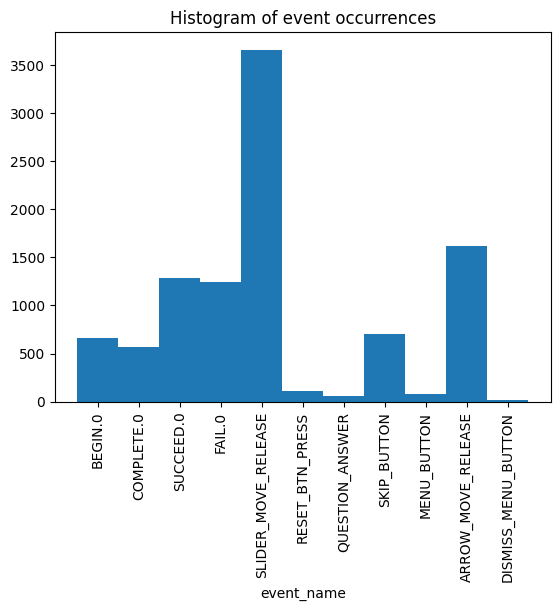

In [83]:
column_to_visualize = "event_name"
f, ax = plt.subplots()
ax.hist(df_events[column_to_visualize], bins=np.arange(12)-0.5)
ax.tick_params(axis='x', labelrotation=90)
ax.set_xlabel(column_to_visualize)
ax.set_title("Histogram of event occurrences")

### Distribution of activity

Text(0.5, 1.0, 'Histogram of events by session')

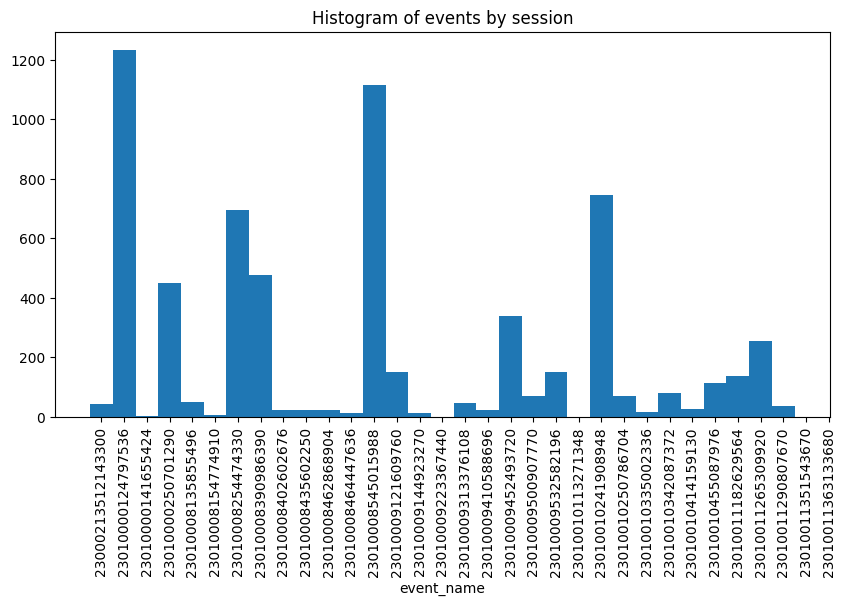

In [91]:
f, ax = plt.subplots(figsize=(10, 5))
ax.hist(df_events['session_id'], bins=np.arange(32)-0.5)
ax.tick_params(axis='x', labelrotation=90)
ax.set_xlabel(column_to_visualize)
ax.set_title("Histogram of events by session")

### Simple comparison of play styles

In [102]:
comparison_data = df_events[['event_name', 'session_id']]
slider_per_session = comparison_data[comparison_data['event_name'] == "SLIDER_MOVE_RELEASE"].groupby('session_id').count()
arrow_per_session = comparison_data[comparison_data['event_name'] == "ARROW_MOVE_RELEASE"].groupby('session_id').count()
# print(slider_per_session['event_name'].count())
session_counts = slider_per_session.merge(arrow_per_session, on='session_id')
print(session_counts)

                   event_name_x  event_name_y
session_id                                   
23010000124797536           382            33
23010000250701290           174            12
23010008254474330           349             7
23010008390986390           143           171
23010008545015988           243           517
23010009121609760            67             4
23010009452493720           113           102
23010009500907770            42             1
23010009532582196            86            48
23010010241908948           365             4
23010010342087372            27             3
23010010414159130            19             4
23010011182629564            42             5
23010011265309920           102             3
23010011363133680           167             7
23010011413757070            58             1
23010011472840150           227           626
23010011490402724           337             2
23010012164911492             2             1
23010013015830320            20   

Text(0, 0.5, 'Arrow Moves')

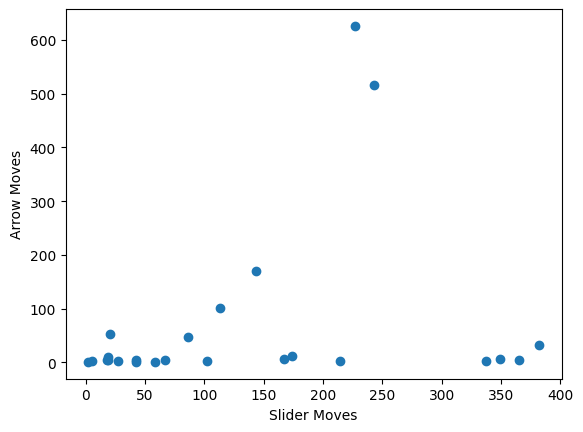

In [103]:
f, ax = plt.subplots()
ax.scatter(session_counts['event_name_x'], session_counts['event_name_y'])
ax.set_xlabel("Slider Moves")
ax.set_ylabel("Arrow Moves")